In [23]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

![](./imgs/curve.png)

In [24]:
data = load_boston()
#波士顿数据集非常简单，但它所涉及到的问题却很多
X = data.data
y = data.target

In [25]:
Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.3,random_state=420)
reg = XGBR(n_estimators=100).fit(Xtrain,Ytrain)
reg.predict(Xtest) #传统接口predict
reg.score(Xtest,Ytest) #你能想出这里应该返回什么模型评估指标么？
MSE(Ytest,reg.predict(Xtest))
reg.feature_importances_
#树模型的优势之一：能够查看模型的重要性分数，可以使用嵌入法进行特征选择

array([0.01902167, 0.0042109 , 0.01478317, 0.00553536, 0.02222195,
       0.37914094, 0.01679687, 0.04698721, 0.04073574, 0.05491758,
       0.0668422 , 0.00869463, 0.32011184], dtype=float32)

In [26]:
reg = XGBR(n_estimators=100)
CVS(reg,Xtrain,Ytrain,cv=5).mean()

0.799506280269948

In [27]:
#这里应该返回什么模型评估指标，还记得么？
#严谨的交叉验证与不严谨的交叉验证之间的讨论：训练集or全数据？
CVS(reg,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

-16.215644658473447

In [28]:
#来查看一下sklearn中所有的模型评估指标
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [29]:
#使用随机森林和线性回归进行一个对比
rfr = RFR(n_estimators=100)
CVS(rfr,Xtrain,Ytrain,cv=5).mean()
CVS(rfr,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

In [29]:
lr = LinearR()
CVS(lr,Xtrain,Ytrain,cv=5).mean()
CVS(lr,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

-25.349507493648453

In [30]:
#开启参数slient：在数据巨大，预料到算法运行会非常缓慢的时候可以使用这个参数来监控模型的训练进度
reg = XGBR(n_estimators=10,silent=False)
CVS(reg,Xtrain,Ytrain,cv=5,scoring='neg_mean_squared_error').mean()

[11:03:07] WARNING: /home/gavin/Software/xgboost/src/learner.cc:489: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:03:07] WARNING: /home/gavin/Software/xgboost/src/learner.cc:489: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:03:07] WARNING: /home/gavin/Software/xgboost/src/learner.cc:489: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verifi

-18.63373361656663

### 学习率调节

In [63]:
def plot_learning_curve(estimator,title, X, y,
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                        ):
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            # ,random_state=420
                                                            ,n_jobs=n_jobs)
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    
    
    # 计算偏差与方差
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    #在中位数曲线的上下描绘出标准差的范围，以带颜色的透明度为0.1的区域显示
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Test score")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.legend(loc="best")
    
    return ax

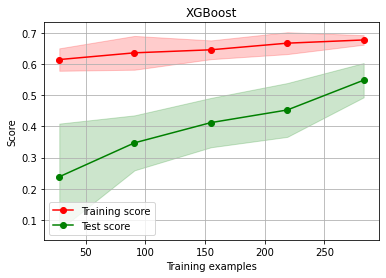

In [64]:
cv = KFold(n_splits=5, shuffle = True, random_state=42)
plot_learning_curve(XGBR(n_estimators=5, random_state=420)
                    ,"XGBoost", Xtrain, Ytrain, ax=None,cv=cv
                   )
plt.show()

结论：训练集上的表现展示了模型的学习能力，测试集上的表现展示了模型的泛化能力，通常模型在测试集上的表现不太可能超过训练集，  
因此我们希望我们的测试集的学习曲线能够努力逼近我们的训练集的学习曲线。

### 方差偏差困境

100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517
100 0.8320924479019667 0.005344209691331517 0.03353715574288529


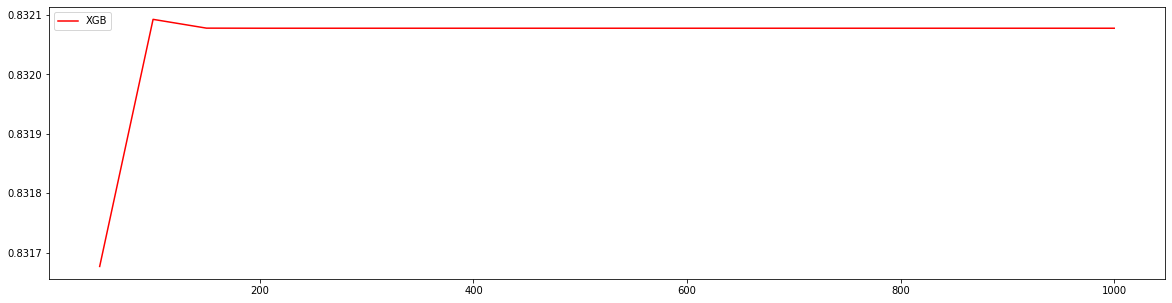

In [54]:
axisx = range(50,1050,50)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
    #计算泛化误差的可控部分
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
#打印R2最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的R2
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
#打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

In [55]:
#验证模型效果是否提高了？
time0 = time()
print(XGBR(n_estimators=100,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)
time0 = time()
print(XGBR(n_estimators=660,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)
time0 = time()
print(XGBR(n_estimators=180,random_state=420).fit(Xtrain,Ytrain).score(Xtest,Ytest))
print(time()-time0)

0.9050988954757183
0.2049424648284912
0.9050526024842831
0.18665337562561035
0.9050526024842831
0.1323850154876709


### 每一次的迭代模型选择

In [66]:
for booster in ["gbtree","gblinear","dart"]:
    reg = XGBR(n_estimators=180
                , learning_rate=0.1
                , random_state=420
                , booster=booster
              ).fit(Xtrain,Ytrain)
    
    print(booster)
    print(reg.score(Xtest,Ytest)) #自己找线性数据试试看"gblinear"的效果吧

gbtree
0.9260984298390122
gblinear
0.6520927677892084
dart
0.9260984373654244


### 目标函数的调节

In [75]:
#默认reg:linear
reg = XGBR(n_estimators=180,random_state=420).fit(Xtrain,Ytrain)
reg.score(Xtest,Ytest)

0.9050526024842831

In [76]:
MSE(Ytest,reg.predict(Xtest))

8.835224213421986

In [81]:
#xgb实现法
import xgboost as xgb
#使用类Dmatrix读取数据
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)
#非常遗憾无法打开来查看，所以通常都是先读到pandas里面查看之后再放到DMatrix中
dtrain

In [78]:
#写明参数，silent默认为False，通常需要手动将它关闭
param = {'silent':True,'objective':'reg:squarederror',"eta":0.1}
num_round = 180
#类train，可以直接导入的参数是训练数据，树的数量，其他参数都需要通过params来导入
bst = xgb.train(param, dtrain, num_round)
#接口predict
from sklearn.metrics import r2_score
r2_score(Ytest,bst.predict(dtest))

[10:20:56] WARNING: /home/gavin/Software/xgboost/src/learner.cc:489: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.9260984298390122

In [79]:
MSE(Ytest,bst.predict(dtest))

6.87682821415069

[学习曲线(learning curve)来判断模型状态：过拟合欠拟合](https://blog.csdn.net/geduo_feng/article/details/79547554?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-1.pc_relevant_is_cache&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-1.pc_relevant_is_cache)